# Axial Drilling Site Figures
Site figures for the Axial Drilling Proposal.

---
## Install Some Packages
These should be installed into a Conda environment soon.

In [ ]:
!conda install -qy gmt=6.1.1

In [ ]:
!pip install git+https://github.com/GenericMappingTools/pygmt.git@c6f154b9916eb96e0be14740ce8b8b79c49e10f2

---
## Load Data as Globals

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import pygmt

In [2]:
data_dir = '../data/'
output_dir = '../output/'
bathy_grd = 'AxialSummit_MAUV_and_Topo1mSq.grd'

In [3]:
holes_df = pd.read_json(data_dir + 'holes.json', orient="records", lines=True)
spiral_df = pd.read_json(data_dir + 'spiral.json', orient="records", lines=True)
jason_df = pd.read_json(data_dir + 'jason.json', orient="records", lines=True)
lava_2011_df = pd.read_json(data_dir + 'lava_2011.json', orient="records", lines=True)
lava_1998_df = pd.read_json(data_dir + 'lava_1998.json', orient="records", lines=True)
ooi_cables_df = pd.read_json(data_dir + 'ooi_cables.json', orient="records", lines=True)
ooi_df = pd.read_json(data_dir + 'ooi.json', orient="records", lines=True)
international_df = pd.read_json(data_dir + 'international.json', orient="records", lines=True)
vents_df = pd.read_json(data_dir + 'vents.json', orient="records", lines=True)

In [4]:
bathy_ds = xr.open_zarr(data_dir + 'bathy.zarr')
thickness_ds = xr.open_zarr(data_dir + 'thickness.zarr')
thickness_interp_ds = xr.open_zarr(data_dir + 'thickness_interp.zarr')

---
## Drop Sites
Here we drop sites 5A and 9A that are no longer used.

In [5]:
holes_df = holes_df.drop([4, 8]).reset_index(drop=True)
holes_df

name        lat         lon  depth  thickness   d_1  d_2  d_3  d_4  \
0  AXIAL-01B  45.925800 -129.978800  -1520        703     0  213  421  704   
1  AXIAL-02B  45.923931 -129.978170  -1523        643   213    0  325  491   
2  AXIAL-03B  45.924054 -129.973988  -1530        604   421  325    0  535   
3  AXIAL-04B  45.919632 -129.976727  -1533        560   704  491  535    0   
4  AXIAL-06A  45.921980 -129.968270  -1543        547   920  798  500  706   
5  AXIAL-07A  45.915250 -129.975270  -1545        577  1204  990  983  500   
6  AXIAL-08A  45.925800 -129.972350  -1533        610   500  497  232  765   

    d_5  d_6   d_7   d_8   d_9  
0  1388  920  1204   500  1888  
1  1259  798   990   497  1756  
2   967  500   983   232  1467  
3  1071  706   500   765  1525  
4   468    0   924   529   967  
5  1095  924     0  1194  1432  
6   972  529  1194     0  1462

---
## Figure Function

In [6]:
def sitefig():
    
    # calculate mid-points used in the Mercator projection for the central meridian and standard parallel
    NS = (N-S)*0.5+S
    EW = (W-E)*0.5+E
    
    # start new figure
    fig = pygmt.Figure()

    # update shading
    cmd = 'gmt grdgradient %s%s -Gshading.grd -R/%f/%f/%f/%f -A45 -Ne1' % (data_dir, bathy_grd, W, E, S, N)
    os.system(cmd);
    
    # bathy image
    fig.grdimage('%s%s' % (data_dir, bathy_grd), region=[W, E, S, N], projection='M%s/%s/6i' % (EW, NS),
             shading='shading.grd', cmap='sites.cpt', Q='')
    
    # jason events
    jason_color = 'aliceblue'
    if plot_jason:
        fig.plot(jason_df.lon, jason_df.lat, style='c0.014i', color=jason_color, pen='0p,black@100')

    # lava outlines
    color_1998 = 'blue'
    thickness_1998 = '1.5p'
    for name, group in lava_1998_df.groupby('area'):
        fig.plot(group.lon.values, group.lat.values, W='%s,%s' % (thickness_1998, color_1998))
    color_2011 = 'cyan'
    thickness_2011 = '1.5p'
    for name, group in lava_2011_df.groupby('area'):
        fig.plot(group.lon.values, group.lat.values, W='%s,%s' % (thickness_2011, color_2011))

    # cables
    cable_color = 'black'
    cable_thickness = '2p'
    for cable in ooi_cables_df.name.unique():
        cable_df = ooi_cables_df.loc[ooi_cables_df.name == cable]
        fig.plot(cable_df.lon.values, cable_df.lat.values, W='%s,%s' % (cable_thickness, cable_color))
    
    for transect in transects:
        fig.plot(transect[0], transect[1], W=transect[2])

    # international district
    id_color = 'white'
    fig.plot(-129.9795, 45.9264, style='a0.2i', color='%s' % id_color, pen='0.5p,black')
    
    # primary sites
    for i in primary:
        fig.plot(holes_df.iloc[i].lon, holes_df.iloc[i].lat, style='c0.1i', color='yellow', pen='1p,black')

    # alternate sites
    for i in alternate:
        fig.plot(holes_df.iloc[i].lon, holes_df.iloc[i].lat, style='c0.1i', color='darkgrey', pen='1p,black') 

    # site label offsets
    label_dx = 0.54
    label_dy = 0.25
    label_offsets = [
        (-label_dx, -label_dy),
        (label_dx, -label_dy),
        (label_dx, label_dy*0.75),
        (label_dx, -label_dy),
        (-label_dx, -label_dy),
        (-label_dx, -label_dy),
        (label_dx, label_dy),
        (label_dx, label_dy),
        (-label_dx, -label_dy),]

    # site labels
    for i in primary + alternate:
        fig.text(x = holes_df.iloc[i].lon, y = holes_df.iloc[i].lat, text = holes_df.iloc[i]['name'], D='%fi/%fi+v1p' % label_offsets[i],
            font='9p,Helvetica-Bold,black', C='3p/3p+tO', G='lightgrey', W='1p,black')

    # scale bar
    dx = W + 129.988
    dy = S - 45.912
    transparency = 50 # higher is more transparent
    pygmt.config(FONT_ANNOT_PRIMARY='7p,Helvetica')
    fig.legend('blank_legend.txt', position='x4.645i/0.495i/2.52i/0.38i', F='+gwhite@%i+p0.3p,black' % transparency)
    fig.basemap(L='fx4.6i/0.4i/%s/1000e' % NS)
    fig.text(x = -129.9604+dx, y = 45.91288+dy, text='Distance (m)', font='7p,Helvetica')
    
    # legend
    # S [dx1 symbol size fill pen [ dx2 text ]]
    legend_shift = 0
    if plot_jason:
        legend_shift = 0.15
    pygmt.config(FONT_ANNOT_PRIMARY='7p,Helvetica')
    with open('legend.txt', 'w') as f:
        f.write('S 0.12i c 0.1i yellow 1p,black 0.3i Primary Site\n')
        f.write('G 0.05i\n')
        f.write('S 0.12i c 0.1i darkgrey 1p,black 0.3i Alternate Site\n')
        f.write('G 0.05i\n')
        f.write('S 0.12i a 0.14i %s 0.5p,black 0.3i International District\n' % id_color)
        f.write('G 0.05i\n')
        if plot_jason:
            f.write('S 0.12i c 0.03i %s - 0.3i Jason Imagery\n' % jason_color)
            f.write('G 0.05i\n')
        
        f.write('S 0.12i - 0.2i - %s,%s 0.3i OOI Cables\n' % (cable_thickness, cable_color))    
        f.write('G 0.05i\n')
        f.write('S 0.12i - 0.2i - %s,%s 0.3i 1998 Eruption\n' % (thickness_1998, color_1998))
        f.write('G 0.05i\n')
        f.write('S 0.12i - 0.2i - %s,%s 0.3i 2011 Eruption\n' % (thickness_2011, color_2011))  
    
    fig.legend('legend.txt', position='x5.2i/4.65i/1.31i/%si' % str(2.15+legend_shift), F='+gwhite@%i+p0.3p,black' % transparency)
    
    # colorbar
    text_shift = 0
    if plot_jason:
        text_shift = 0.00065
    pygmt.config(MAP_FRAME_PEN='0.5p', MAP_TICK_LENGTH_PRIMARY='0.03i')
    fig.colorbar(D='x4.616i/%si/-1i/0.2i' % str(3.088-legend_shift), C='sites.cpt', W=-1, B='p20')
    fig.text(x = -129.9565+dx, y = 45.9249+dy-text_shift, text='Depth (m)', angle=90)
    
    # frame and north arrow
    pygmt.config(FONT_ANNOT_PRIMARY='9p,Helvetica')
    pygmt.config(FONT_TITLE='9p,Helvetica')
    fig.basemap(frame='a0.004d', Td='jTR+o0.02i/%si+w2c+l' % str(1.36 + legend_shift))
        
    return fig

---
## All Sites

In [7]:
pygmt.config(MAP_SCALE_HEIGHT='0.1i', MAP_FRAME_WIDTH='0.05i', FORMAT_GEO_MAP='D.xxx',
            FONT_ANNOT_PRIMARY='9p,Helvetica', FONT_ANNOT_SECONDARY='10p',
            FONT_LABEL='9p,Helvetica-Bold',
            MAP_FRAME_AXES='WeSn', PS_LINE_JOIN='round');

In [8]:
cmd = 'gmt grd2cpt %s%s -L-1600/-1500 -T-1600/-1500/10 > sites.cpt' % (data_dir, bathy_grd)
print(cmd)
os.system(cmd);

gmt grd2cpt ../data/AxialSummit_MAUV_and_Topo1mSq.grd -L-1600/-1500 -T-1600/-1500/10 > sites.cpt


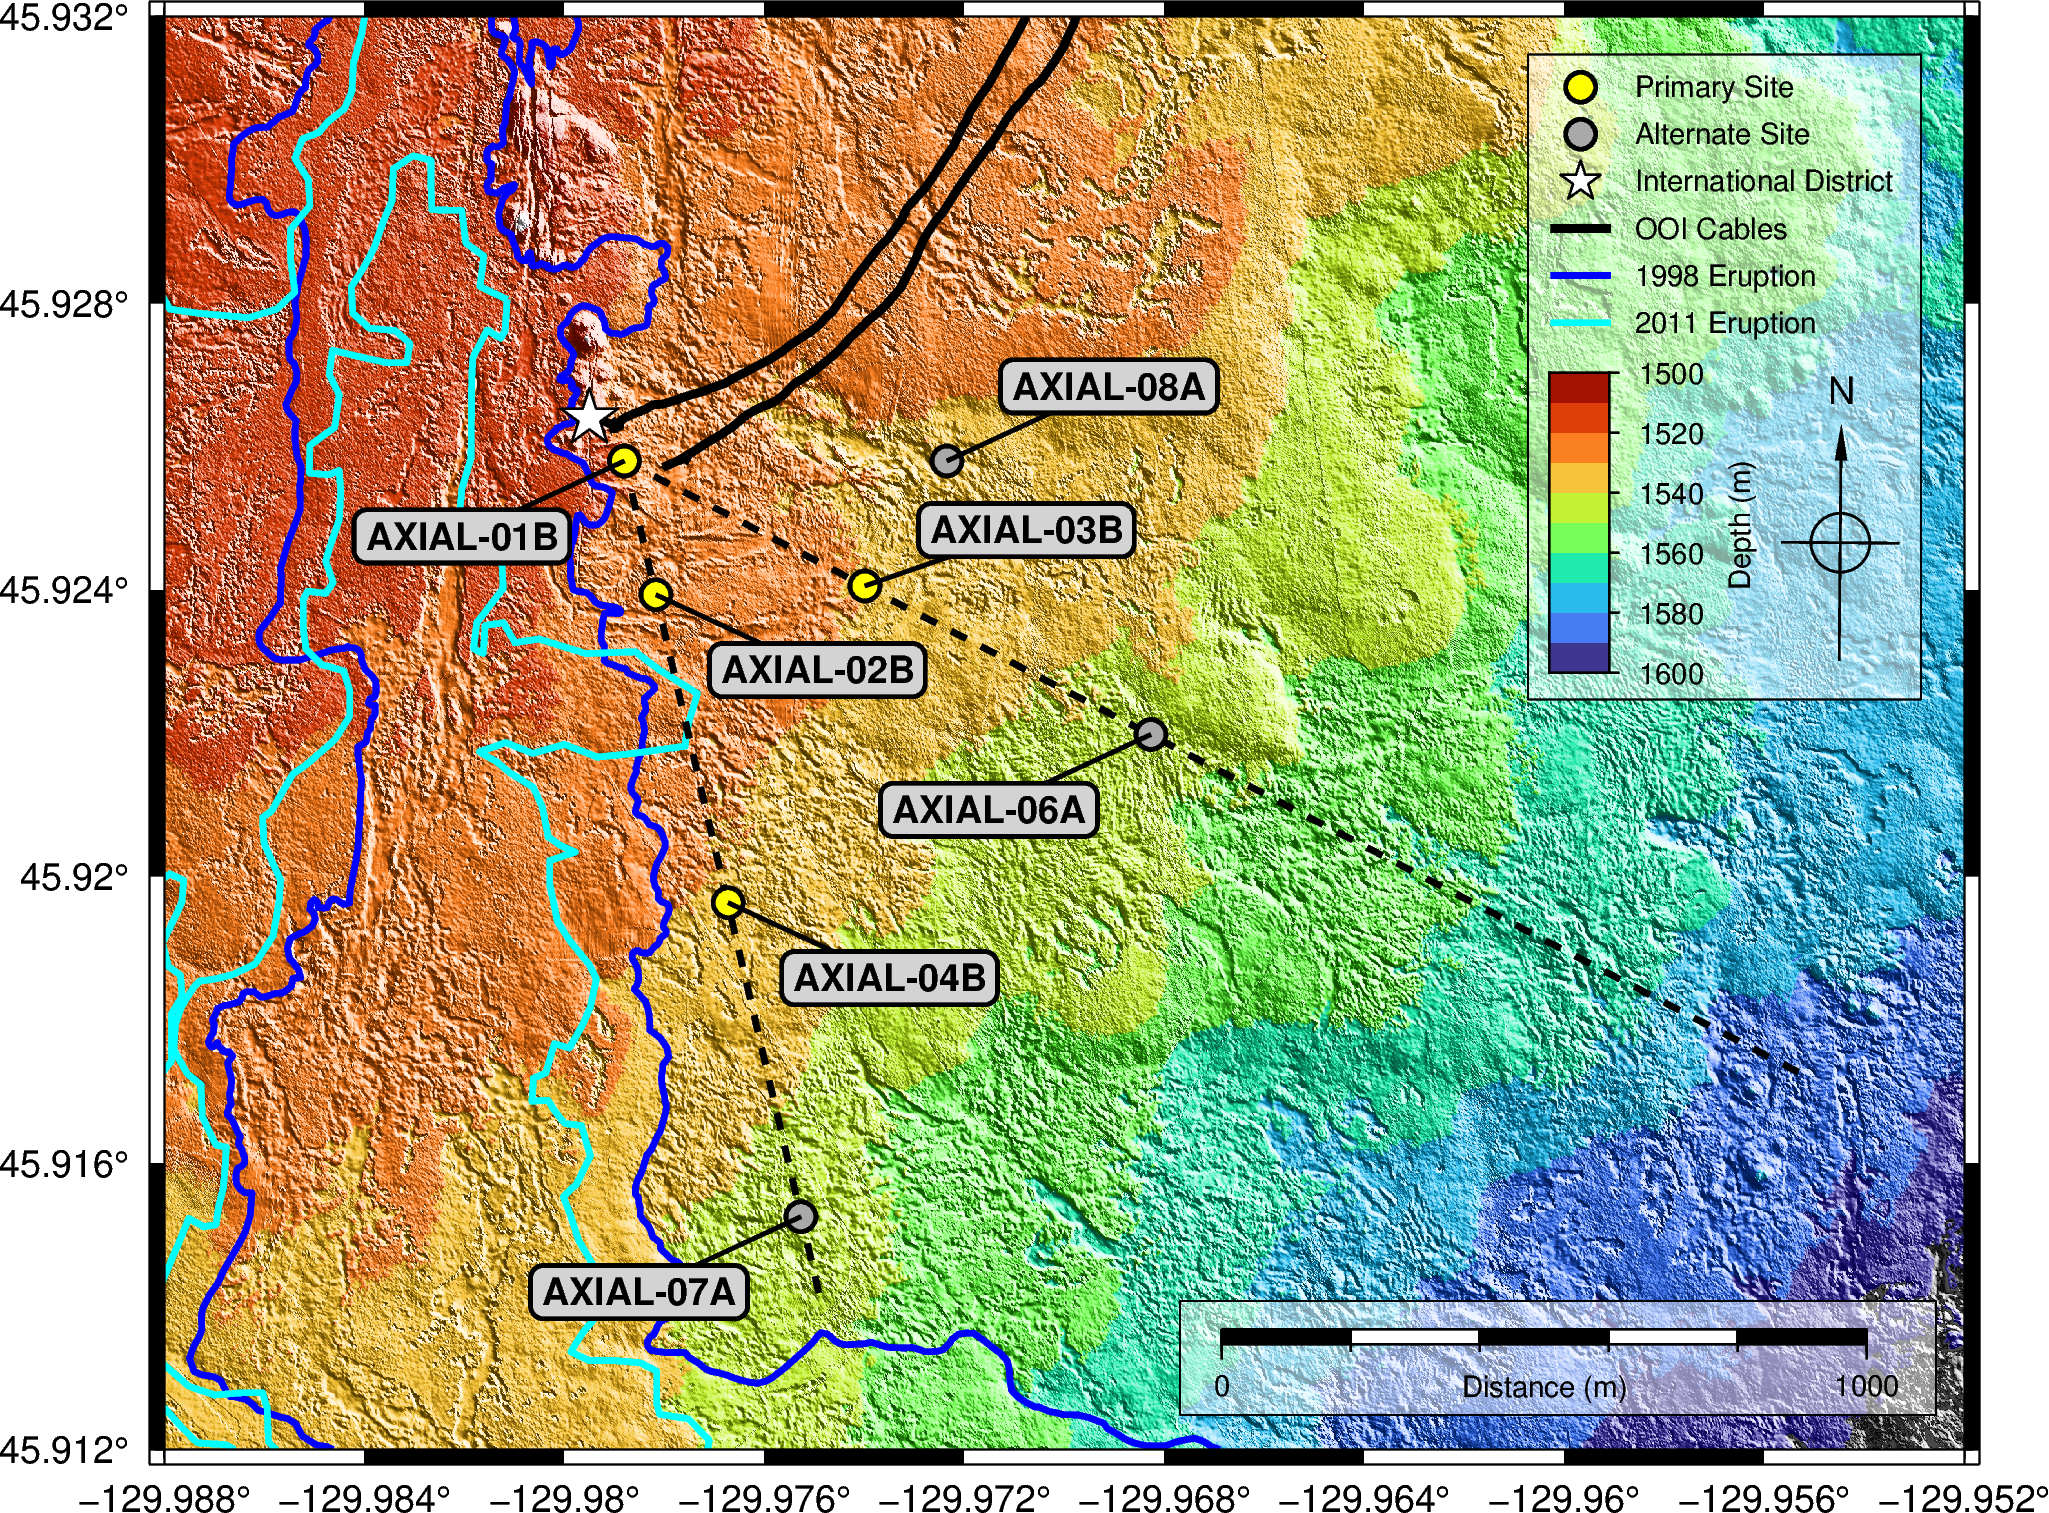

In [9]:
N = 45.932
S = 45.912
E = -129.952
W = -129.988
transects = [[np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.97485),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.914), '1.5p,black,4_4'],
         [np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.9553),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.91726), '1.5p,black,4_4']]

primary = [0, 1, 2, 3]
alternate = [4, 5, 6]

plot_jason = False

fig = sitefig()
fig.show(width=700)

In [10]:
#fig.savefig(output_dir + 'all_sites.pdf')
fig.savefig(output_dir + 'all_sites.png', transparent=True, dpi=400)

---
## Site 01

In [ ]:
dx = -0.004
dy = 0.004

N = 45.932+dy
S = 45.912+dy
E = -129.952+dx
W = -129.988+dx

lat = holes_df[holes_df['name']=='AXIAL-01B'].lat.values
transects = [[np.append(-129.983, -129.968), np.append(lat, lat), '1p,black,4_4']]

primary = [0]
alternate = [6]

plot_jason = True

fig = sitefig()
fig.show(width=700)

In [ ]:
#fig.savefig(output_dir + 'site01.pdf')
fig.savefig(output_dir + 'site01.png', transparent=True, dpi=400)

---
## Site 02

In [ ]:
dx = -0.008
dy = 0.002

N = 45.932+dy
S = 45.912+dy
E = -129.952+dx
W = -129.988+dx

transects = [[np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.97485),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.914), '1p,black,4_4']]

primary = [1]
alternate = []

fig = sitefig()
fig.show(width=700)

In [ ]:
#fig.savefig(output_dir + 'site02.pdf')
fig.savefig(output_dir + 'site02.png', transparent=True, dpi=400)

---
## Site 03

In [ ]:
dx = 0
dy = 0

N = 45.932+dy
S = 45.912+dy
E = -129.952+dx
W = -129.988+dx

transects = [[np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.9553),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.91726), '1p,black,4_4']]

primary = [2]
alternate = [4]

fig = sitefig()
fig.show(width=700)

In [ ]:
#fig.savefig(output_dir + 'site03.pdf')
fig.savefig(output_dir + 'site03.png', transparent=True, dpi=400)

---
## Site 04

In [ ]:
dx = -0.004
dy = -0.004

N = 45.932+dy
S = 45.912+dy
E = -129.952+dx
W = -129.988+dx

transects = [[np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.97485),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.914), '1p,black,4_4']]

primary = [3]
alternate = [5]

fig = sitefig()
fig.show(width=700)

In [ ]:
#fig.savefig(output_dir + 'site04.pdf')
fig.savefig(output_dir + 'site04.png', transparent=True, dpi=400)

---
## Sites 01, 02, and 03

In [ ]:
N = 45.932
S = 45.912
E = -129.952
W = -129.988
transects = [[np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.97485),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.914), '1.5p,black,4_4'],
         [np.append(holes_df[holes_df['name']=='AXIAL-01B'].lon.values, -129.9553),
         np.append(holes_df[holes_df['name']=='AXIAL-01B'].lat.values, 45.91726), '1.5p,black,4_4']]

primary = [0, 1, 2]
alternate = []

plot_jason = False

fig = sitefig()
fig.show(width=700)

In [ ]:
fig.savefig(output_dir + 'sites123.png', transparent=True, dpi=400)